In [1]:
# imports the numpy and matplotlib. Also ensures plots appear inline
# import matplotlib.pyplot as plt
# import numpy as np
%pylab inline
import pandas as pd
import time

plt.style.use("seaborn-darkgrid")

# # update rcparams matplotlib to ensure same style for the different plots
nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 12pt font in plots, to match 12pt font in document
        "axes.labelsize": 12,
        "font.size": 12,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        # set line style axis and line plots
        "lines.linewidth": 1,
        "axes.edgecolor": "0.15",
        "axes.linewidth": 1.25
}

# plt.rcParams.update(nice_fonts)

Populating the interactive namespace from numpy and matplotlib


In [2]:
class SIR(object):
    """
    Mathematical representation of SIR model
    -------------------------------------
    Parameters: y0 = the initial populations
                data structure (array like)
                
                t = time interval (array like)
                parameters 
    """
    def __init__(self, model, y0, t, parameters, update):
    
        self.model = model
        self.population = y0
        self.total_pop = sum(y0)
        self.time = t
        self.parameters = parameters
        self.update = update
        self.data = []
        self.sim = 0
        
    def rates_SIR(self, pop):
        """
        Returns an array of propensities given a set of parameters
        and an array of populations.
        """
        
        # Unpack population
        X, Y, Z = pop
        
        if self.model == "SIR":
            
            # Unpack parameters
            beta, gamma = self.parameters

            return np.array([beta * X * Y / self.total_pop, gamma * Y])
        
        elif self.model == "demography":
            
            # unpack paramaters
            beta, gamma, mu, nu, delta = self.parameters
            
            
            return np.array([mu * self.total_pop, beta * X * Y / self.total_pop, 
                             gamma * Y, nu * X, nu * Y, nu * Z, delta * np.sqrt(N)])
            
    
    def choose_event(self, probs, q=0):
        """
        Randomly sample an index with probability given by probs.
        """

        # Find index
        i = 0
        p_sum = 0.0
        while p_sum < q:
            p_sum += probs[i]
            i += 1
        return i - 1

    # Function to draw time interval and choice of reaction
    def event_handler(self, pop):
        """
        Draws a reaction and the time it took to do that reaction.
        """
        # Compute rates events
        rates = self.rates_SIR(pop)

        # Sum of propensities
        rates_sum = rates.sum()

        # Compute time to next event
        dt = - np.log(np.random.uniform(0.0, 1.0)) / rates_sum

        # Draw reaction from this distribution
        probs = self.choose_event(rates, q=rates_sum*np.random.uniform(0.0, 1.0))

        return probs, dt
    
    def direct_Gillepsie(self):
        
        # create first data point
        t = 0.0
        pop = self.population.copy()
        
        data_point = {"Time": t, "X": pop[0], "Y": pop[1], "Z": pop[2], 
                      "sim": self.sim, "time_array": self.time ,  
                      "pop_size": self.total_pop}
        self.data.append(data_point)
        
        # start algorithm
        while t < self.time:
            
            # checks if infected are "extincted", if so stop algorithm
#             if pop[1] == 0:
#                 break
            
            # determine events with correspoding time jump
            event, dt = self.event_handler(pop)
            
            # Update the population
            pop += self.update[event,:]
            
            # Increment time
            t += dt
            
            # keep track of data point
            data_point = {"Time": t, "X": pop[0], "Y": pop[1], "Z": pop[2], 
                      "sim": self.sim, "time_array": self.time ,  
                      "pop_size": self.total_pop}
            self.data.append(data_point)
        
    def plot_dynamics(self):
        
        self.data = pd.DataFrame(self.data)
        plt.figure(figsize=(5.5, 4))
        ax = self.data.plot(x="Time", y=["X", "Y", "Z"], color=["b", "y", "g"])
        ax.set_xlabel("Time (days)")
        ax.set_ylabel("Population")
        ax.legend(["Susceptibles", "Infected", "Recovered"])
        plt.show()
        
    def plot_simulation(self, n_sim, pop_sizes, time_periods):
        """
        """
        
        for pop_size in pop_sizes:
            
            fig, axes = plt.subplots(1, len(time_periods), figsize=(13, 5))
            
            for i, time in enumerate(time_periods):
                
                
                for sim in range(n_sim):
                    
                    df = self.data.loc[((self.data["pop_size"] == pop_size) 
                                        & (self.data["time_array"] == time)
                                       & (self.data["sim"] == sim)), 
                                       ["Time", "X", "Y", "Z"]]
                    
                    df.plot(x="Time", y=["X", "Y", "Z"], ax=axes[i], 
                            color=["b", "y", "g"], alpha=0.25)
                    
                axes[i].set_xlabel("Time (days)")
                axes[i].set_ylabel("Population")
                axes[i].legend(["Susceptibles", "Infected", "Recovered"])

            plt.show()

        
    def simulation(self, n_sim, pop_sizes, time_periods, perc):
        
        self.data = []
        
        for size in pop_sizes:
            self.total_pop  = size
            X = perc * size
            Y, Z = self.total_pop - X, 0
            self.population = np.array([X, Y, Z], dtype=int)
            
            for time in time_periods:
                self.time =  time
                
                for sim in range(n_sim):
                    self.sim = sim
                    self.direct_Gillepsie()

        self.data = pd.DataFrame(self.data, dtype=object)
#         self.data.to_csv("simulations_stochastic_SIR.csv")
#         return self.data

c:\users\wiebe\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in double_scalars


<Figure size 396x288 with 0 Axes>

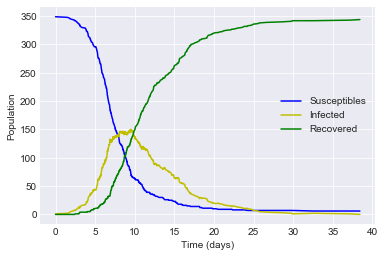

In [3]:
# np.random.seed(123)
N = 350
X = N - 1
Y, Z = N - X, 0
y0 = np.array([X, Y, Z], dtype=int)
parameters = np.array([1.0, 0.25], dtype=float)
T = 200
update_basic = np.array([[-1, 1, 0], [0, -1, 1]], dtype=int)

sir = SIR("SIR" ,y0, T, parameters, update_basic)
# data = sir.direct_Gillepsie()
sir.direct_Gillepsie()
sir.plot_dynamics()

<Figure size 396x288 with 0 Axes>

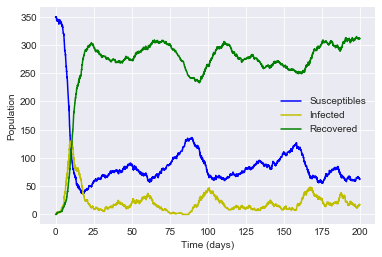

Notebook ran in 0.268 minutes.


In [4]:
# np.random.seed(45)
N = 350
X = N - 1
Y, Z = N - X, 0
T = 200
delta = 0.
y0 = np.array([X, Y, Z], dtype=int)
parameters = np.array([1.0, 0.25, 1 / 60, 1 / 60, delta], dtype=float)
update_demography = np.array([[1, 0, 0], [-1, 1, 0], [0, -1, 1], 
                             [-1, 0, 0], [0, -1, 0], [0, 0, -1], [0,1,0]], 
                             dtype=int)

n_sim = 10
pop_sizes = [500, 1000, 5000]
time_periods = [50, 100]
perc = 0.90


sir_demo = SIR("demography", y0, T, parameters, update_demography)
sir_demo.direct_Gillepsie()
sir_demo.plot_dynamics()
start = time.time()
sir_demo.simulation(n_sim, pop_sizes, time_periods, perc)
print('Notebook ran in {:2.3} minutes.'.format((time.time()-start)/60))
# sir_demo.plot_simulation(n_sim, pop_sizes, time_periods)

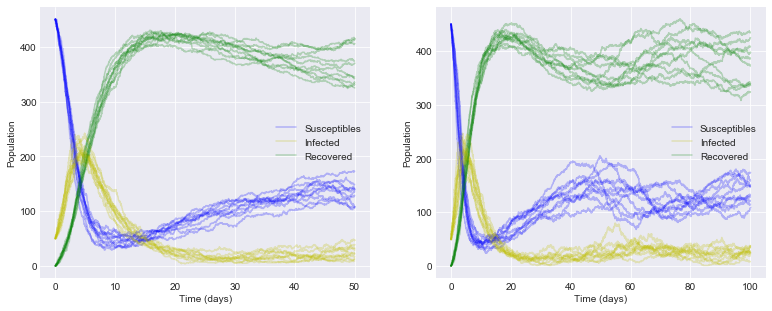

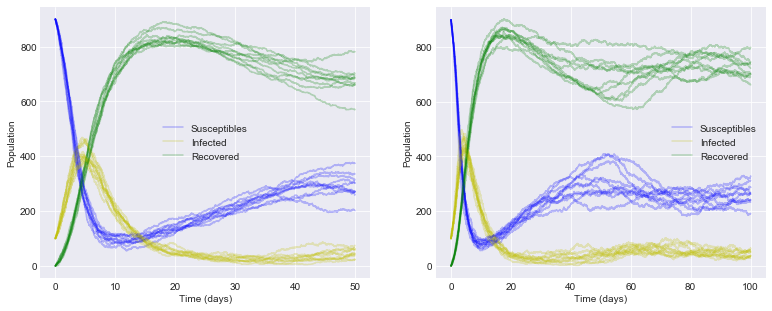

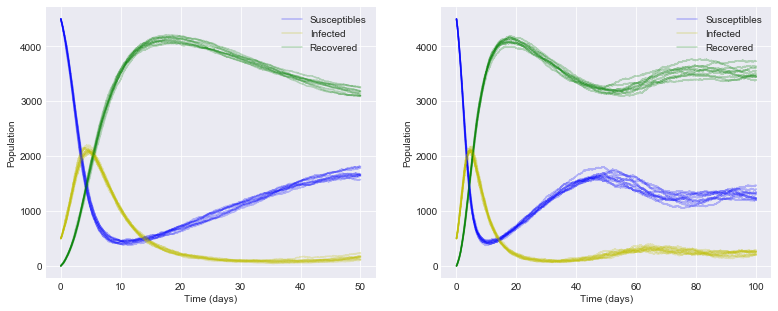

In [5]:
sir_demo.plot_simulation(n_sim, pop_sizes, time_periods)